## Customer Base Analysis with BG NBD Model

**The model can be used to determine the expected repeat visits for customers in order to determine a customers lifetime value. It can also be used to determine whether a customer has churned or is likely to churn soon.**

In [2]:
# for dataframe manipulations
import pandas as pd

# for statistics
import numpy as np
import scipy

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# reading the dataset
df = pd.read_excel('bgnbd.xls', sheet_name = 'Raw Data').set_index('ID')

# lets check the shape of the data
df.shape

(2357, 3)

In [3]:
# lets check the head of the data
df.head()

,x,t_x,T
ID,,,
1,2,30.428571,38.857143
2,1,1.714286,38.857143
3,0,0.000000,38.857143
4,0,0.000000,38.857143
5,0,0.000000,38.857143


## In this dataset:

* ```x is the number of repeat purchases from this customer since the first purchase (frequency)```
* ```tx is the date of the most recent purchase in weeks since the customer’s first purchase (recency)```
* ```T is the time to be considered in weeks since the customer’s first purchase```

## Assumptions

This model has a number of assumptions associated with it. These are as follows:

#### 1. While active, transactions made by a customer in time period t is Poisson distributed with mean λt

Let’s look at the probability distribution of one customer with λ=5:

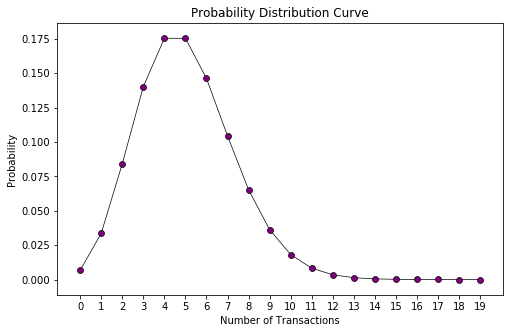

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import poisson

probability_arr = []
distribution = poisson(5)
for transactions in range(0,20):
     probability_arr.append(distribution.pmf(transactions))

plt.figure(figsize=(8,5))
plt.ylabel('Probability')
plt.xlabel('Number of Transactions')
plt.xticks(range(0, 20))
plt.title('Probability Distribution Curve')
plt.plot(probability_arr, color='black', linewidth=0.7, zorder=1)
plt.scatter(range(0, 20), probability_arr, color='purple', edgecolor='black', linewidth=0.7, zorder=2)
plt.show()

#### 2. Differences in transaction rate between customers follows a gamma distribution with shape r and scale α

Let’s take a look at how the probability distributions would look for 100 customers with r=9.0 and α=0.5:

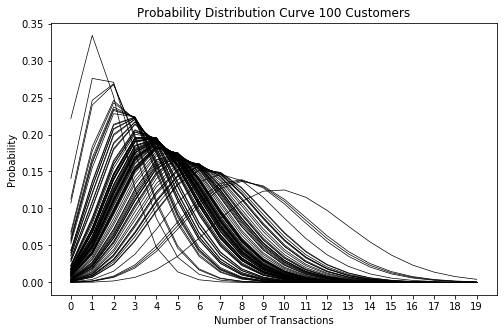

In [6]:
import numpy as np

plt.figure(figsize=(8,5))

for customer in range(0, 100):
    distribution = poisson(np.random.gamma(shape=9, scale=0.5))
    probability_arr = []
    for transactions in range(0,20):
        probability_arr.append(distribution.pmf(transactions))
    plt.plot(probability_arr, color='black', linewidth=0.7, zorder=1)


plt.ylabel('Probability')
plt.xlabel('Number of Transactions')
plt.xticks(range(0, 20))
plt.title('Probability Distribution Curve 100 Customers')

plt.show()

#### 3. Each customer becomes inactive after each transaction with probability p

#### 4. Differences in p follows a beta distribution with shape parameters a and b

Let’s apply a random drop-off with probability p that is beta distributed with parameters a=1.0 and b=2.5 to each of our 100 customers after each transaction and see what this does to our probability distribution curves:

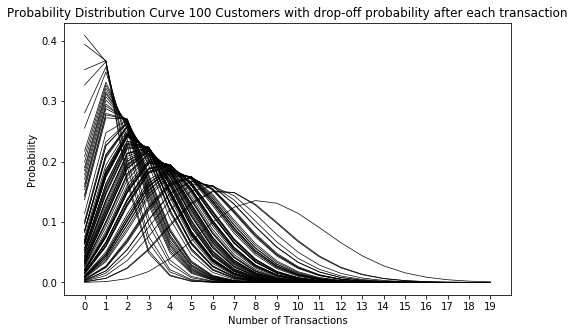

In [8]:
plt.figure(figsize=(8,5))

for customer in range(0, 100):
    distribution = poisson(np.random.gamma(shape=9, scale=0.5))
    probability_arr = []
    beta = np.random.beta(a=1.0, b=2.5)
    cumulative_beta = 0
    for transactions in range(0,20):
        proba = distribution.pmf(transactions)
        cumulative_beta = beta + cumulative_beta - (beta * cumulative_beta)
        inactive_probability = 1 - cumulative_beta
        proba *= inactive_probability
        probability_arr.append(proba)
    probability_arr = np.array(probability_arr)
    probability_arr /= probability_arr.sum()
    plt.plot(probability_arr, color='black', linewidth=0.7, zorder=1)


plt.ylabel('Probability')
plt.xlabel('Number of Transactions')
plt.xticks(range(0, 20))
plt.title('Probability Distribution Curve 100 Customers with drop-off probability after each transaction')

plt.show()

We can see that this transformation moves the distribution to the left. This makes sense as there is an increased likelihood of fewer transactions because after each transaction there is the probability that the customer doesn’t return and this accumulates with each additional transaction.

#### 5. Transaction rate and dropout probability vary independently between customers

## Optimizing Liklihood Function Parameters

Given the above assumptions, the likelihood a customer makes x purchases in a given time period T is:


In [10]:
from scipy.special import gammaln

def negative_log_likelihood(params, x, t_x, T):
    if np.any(np.asarray(params) <= 0):
        return np.inf

    r, alpha, a, b = params

    ln_A_1 = gammaln(r + x) - gammaln(r) + r * np.log(alpha)
    ln_A_2 = (gammaln(a + b) + gammaln(b + x) - gammaln(b) -
           gammaln(a + b + x))
    ln_A_3 = -(r + x) * np.log(alpha + T)
    ln_A_4 = x.copy()
    ln_A_4[ln_A_4 > 0] = (
        np.log(a) -
        np.log(b + ln_A_4[ln_A_4 > 0] - 1) -
        (r + ln_A_4[ln_A_4 > 0]) * np.log(alpha + t_x)
    )
    
    delta =  np.where(x>0, 1, 0)
    
    log_likelihood = ln_A_1 + ln_A_2 + np.log(np.exp(ln_A_3) + delta * np.exp(ln_A_4))
    return -log_likelihood.sum()

* Now we can optimise our parameters. We’ll use the Nelder-Mead Simplex algorithm, which is a heuristic, non-gradient search method to minimise our negative log likelihood cost function.

In [11]:
from scipy.optimize import minimize

scale = 1 / df['T'].max()
scaled_recency = df['t_x'] * scale
scaled_T = df['T'] * scale

def _func_caller(params, func_args, function):
    return function(params, *func_args)

current_init_params = np.array([1.0, 1.0, 1.0, 1.0])
output = minimize(
    _func_caller,
    method="Nelder-Mead",
    tol=0.0001,
    x0=current_init_params,
    args=([df['x'], scaled_recency, scaled_T], negative_log_likelihood),
    options={'maxiter': 2000}
)

r = output.x[0]
alpha = output.x[1]
a = output.x[2]
b = output.x[3]

alpha /= scale

print("r = {}".format(r))
print("alpha = {}".format(alpha))
print("a = {}".format(a))
print("b = {}".format(b))

r = 0.24259412356864324
alpha = 4.413588131347807
a = 0.7929354716520993
b = 2.4259553697230176


In [12]:
## Expected Sales Forecasting

from scipy.special import hyp2f1

def expected_sales_to_time_t(t):
    hyp2f1_a = r
    hyp2f1_b = b
    hyp2f1_c = a + b - 1
    hyp2f1_z = t / (alpha + t)
    hyp_term = hyp2f1(hyp2f1_a, hyp2f1_b, hyp2f1_c, hyp2f1_z)
    
    return ((a + b - 1) / (a - 1)) * (1-(((alpha / (alpha+t)) ** r) * hyp_term))

In [13]:
expected_sales_to_time_t(52)

1.444010643699092

In [14]:
# Period of consideration is 39 weeks. 
# T indicates the length of time since first purchase
n_s = (39 - df['T']).value_counts().sort_index()

n_s.head()

0.142857    18
0.285714    22
0.428571    17
0.571429    20
0.714286    23
Name: T, dtype: int64

18 people made their first transaction on day 1 (1/7 weeks), 22 on day 2 (2/7 weeks), 17 on day 3 (1/7 weeks) etc.

In [15]:
forecast_range = np.arange(0, 78, 1/7.0)

def cumulative_repeat_transactions_to_t(t):
    expected_transactions_per_customer = (t - n_s.index).map(lambda x: expected_sales_to_time_t(x) if x > 0 else 0)
    expected_transactions_all_customers = (expected_transactions_per_customer * n_s).values
    return expected_transactions_all_customers.sum()

cum_rpt_sales = pd.Series(map(cumulative_repeat_transactions_to_t, forecast_range), index=forecast_range)

cum_rpt_sales.tail(10)


76.571429    4109.744742
76.714286    4114.856053
76.857143    4119.961614
77.000000    4125.061441
77.142857    4130.155549
77.285714    4135.243956
77.428571    4140.326675
77.571429    4145.403724
77.714286    4150.475118
77.857143    4155.540873
dtype: float64

So across the next 78 weeks we would expect to make around 4156 repeat transactions from our cohort of customers

## Conditional Expectation

* If we want to calculate the expected sales from a single customer (how many transacations any single customer will make going forward in time period t), we can calculate the conditional expectation for that customer.

In [17]:
def calculate_conditional_expectation(t, x, t_x, T):
    first_term = (a + b + x - 1) / (a-1)
    hyp2f1_a = r + x
    hyp2f1_b = b + x
    hyp2f1_c = a + b + x - 1
    hyp2f1_z = t / (alpha + T + t)
    hyp_term = hyp2f1(hyp2f1_a, hyp2f1_b, hyp2f1_c, hyp2f1_z)
    second_term = (1 - ((alpha + T) / (alpha + T + t)) ** (r + x) * hyp_term)
    delta = 1 if x > 0 else 0
    denominator = 1 + delta * (a / (b + x - 1)) * ((alpha + T) / (alpha + t_x)) ** (r+x)
    return first_term * second_term / denominator